In [1]:
!pip install pmdarima

You should consider upgrading via the '/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
from pathlib import Path
import pyreadr
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels
import patsy
import pmdarima
import statsmodels.formula.api as smf

In [3]:
path = Path(os.getcwd())

In [4]:
base_dir = path.parent.parent

In [5]:
data_in = os.path.join(str(base_dir) , "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir) , "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [6]:
sys.path.append(func)
from py_helper_functions import *

In [7]:
#rds_path = os.path.join(data_in,"houseprices-data-1990-2018.rds")
#result = pyreadr.read_r(rds_path)

In [8]:
csv_path = os.path.join(data_in,"houseprices-data-1990-2018.csv")
data = pd.read_csv(csv_path)

In [9]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
0,1990 jan.,12495.2,12329.0,5.2,5.7,100.225510,100.471193,100.471193,100.225510,5.2,5.7,12495.2,12329.0
1,1990 febr.,12500.7,12399.1,5.2,5.6,100.151430,100.761572,100.761572,100.151430,5.2,5.6,12500.7,12399.1
2,1990 márc.,12503.6,12476.7,5.2,5.4,100.017670,100.992838,100.992838,100.017670,5.2,5.4,12503.6,12476.7
3,1990 ápr.,12536.4,12502.9,5.3,5.4,99.986753,100.990410,100.990410,99.986753,5.3,5.4,12536.4,12502.9
4,1990 máj.,12553.2,12566.3,5.4,5.2,99.791606,100.394583,100.394583,99.791606,5.4,5.2,12553.2,12566.3


### Format dates

In [10]:
data[['year', 'month']] = data['date'].str.split(' ', n=1, expand=True)
month_dict = {'jan.':'01',
              'febr.':'02',
              'márc.':'03',
              'ápr.':'04',
              'máj.':'05',
              'jún.':'06',
              'júl.':'07',
              'aug.':'08',
              'szept.':'09',
              'okt.':'10',
              'nov.':'11',
              'dec.':'12'}
data['month1']='-' + data['month'].map(month_dict)
data['date1']=data['year']+data['month1']
data['date']=pd.to_datetime(data['date1'])
data = data.drop(['year','month','month1','date1'],axis=1)

In [11]:
data.dtypes

date       datetime64[ns]
CANA              float64
CANAN             float64
CAUR              float64
CAURN             float64
LXXRNSA           float64
LXXRSA            float64
ps                float64
pn                float64
us                float64
un                float64
emps              float64
empn              float64
dtype: object

In [12]:
data = data[(data['date'] >= '2000-01-01') & (data['date'] < '2018-01-01')]

In [13]:
data = data.sort_values('date')

In [14]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
120,2000-01-01,14346.8,14132.7,5.0,5.4,100.00000,101.031209,101.031209,100.00000,5.0,5.4,14346.8,14132.7
121,2000-02-01,14390.6,14270.0,5.0,5.4,100.61896,102.043406,102.043406,100.61896,5.0,5.4,14390.6,14270.0
122,2000-03-01,14431.7,14421.3,5.0,5.4,102.12780,103.224699,103.224699,102.12780,5.0,5.4,14431.7,14421.3
123,2000-04-01,14482.4,14451.0,5.1,4.8,103.70410,104.159399,104.159399,103.70410,5.1,4.8,14482.4,14451.0
124,2000-05-01,14550.6,14590.2,5.1,4.8,104.98908,104.924698,104.924698,104.98908,5.1,4.8,14550.6,14590.2


In [15]:
data = data.assign(p=data['pn'],u=data['us'],emp=data['emps'])

In [16]:
data =  data.assign(
        dp = data['p'].diff(),
        p_lag = data['p'].shift(),
        lnp = np.log(data['p']))
data =  data.assign(
        dlnp = data['lnp'].diff(),
        lnp_lag = data['lnp'].shift())
data =  data.assign(
        dlnp_lag = data['dlnp'].shift(),
        du = data['u'].diff(),
        lnemp = np.log(data['emp']))

data['dlnemp'] = data['lnemp'].diff()

In [17]:
data = data.reset_index(drop=True)

In [18]:
data

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,...,emp,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp
0,2000-01-01,14346.8,14132.7,5.0,5.4,100.000000,101.031209,101.031209,100.000000,5.0,...,14346.8,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,9.571282,NaN
1,2000-02-01,14390.6,14270.0,5.0,5.4,100.618960,102.043406,102.043406,100.618960,5.0,...,14390.6,0.618960,100.000000,4.611341,0.006171,4.605170,NaN,0.0,9.574330,0.003048
2,2000-03-01,14431.7,14421.3,5.0,5.4,102.127800,103.224699,103.224699,102.127800,5.0,...,14431.7,1.508840,100.618960,4.626225,0.014884,4.611341,0.006171,0.0,9.577182,0.002852
3,2000-04-01,14482.4,14451.0,5.1,4.8,103.704100,104.159399,104.159399,103.704100,5.1,...,14482.4,1.576300,102.127800,4.641542,0.015317,4.626225,0.014884,0.1,9.580689,0.003507
4,2000-05-01,14550.6,14590.2,5.1,4.8,104.989080,104.924698,104.924698,104.989080,5.1,...,14550.6,1.284980,103.704100,4.653856,0.012315,4.641542,0.015317,0.0,9.585388,0.004698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2017-08-01,16880.1,16816.7,4.7,5.0,266.852921,265.270468,265.270468,266.852921,4.7,...,16880.1,0.614863,266.238058,5.586698,0.002307,5.584391,0.010913,0.0,9.733891,0.001464
212,2017-09-01,16910.3,16902.7,4.6,4.4,267.838649,267.011819,267.011819,267.838649,4.6,...,16910.3,0.985727,266.852921,5.590385,0.003687,5.586698,0.002307,-0.1,9.735678,0.001787
213,2017-10-01,16951.3,17054.4,4.5,4.3,268.278285,268.436825,268.436825,268.278285,4.5,...,16951.3,0.439636,267.838649,5.592025,0.001640,5.590385,0.003687,-0.1,9.738100,0.002422
214,2017-11-01,16978.5,17164.8,4.5,4.3,270.010862,271.060084,271.060084,270.010862,4.5,...,16978.5,1.732577,268.278285,5.598462,0.006437,5.592025,0.001640,0.0,9.739703,0.001603


In [19]:
data['trend']=[i for i in range(1,len(data)+1)]

In [20]:
data['month'] = data['date'].dt.strftime('%m').astype('category')

In [21]:
#spot check data same as in R

In [22]:
assert data.loc[0,'p'] == 100
assert data.loc[0,'u'] == 5
assert data.loc[0,'emp'] == 14346.8
np.testing.assert_almost_equal(data.loc[0,'lnemp'], 9.571282,decimal=5)
assert data.loc[0,'month'] == '01'

In [23]:
np.testing.assert_almost_equal(data.loc[215,'p'],271.5796,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'u'],4.4,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'lnemp'],9.742368,decimal=5)
assert data.loc[215,'month'] == '12'

In [24]:
# GRAPHS part 1

In [25]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)

In [26]:
breaks = date_breaks('1 year')

In [27]:
price_index_plot = (ggplot(data) 
  + geom_line(aes('date','p'),color = color[1], size = 0.5) 
  + scale_y_continuous(limits = [50,300], breaks = seq(50,300,50)) 
  + scale_x_date(breaks = breaks(limits)[::3], labels = date_format("%b%Y")) 
  + labs(y = "Case-shiller Price index",x= "Date (month)") 
  + theme_bw())

In [28]:
breaks(limits)[::3]

[datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2003, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2006, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2012, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)]

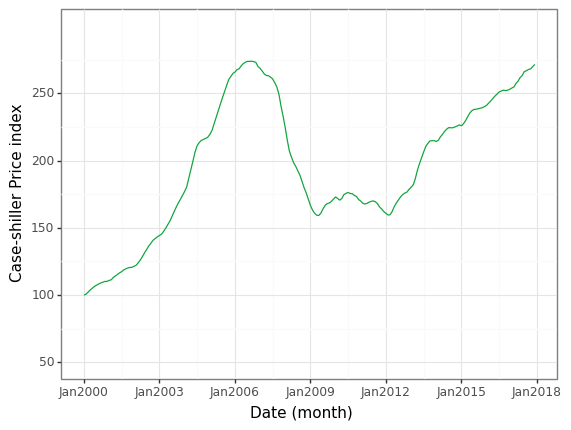

<ggplot: (-9223372036570875995)>

In [29]:
price_index_plot

In [30]:
#GRAPHS part 2

In [31]:
#Create train/holdout data

In [32]:
data_holdout= data.loc[data['date'].dt.year==2017,:]
data_train= data.loc[data['date'].dt.year<2017,:]

In [33]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.47
#R doc
#unitroot_kpss computes the statistic for the
#Kwiatkowski et al. unit root test with linear trend and lag 1.

statsmodels.tsa.stattools.kpss(data['p'],regression='ct', nlags=1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value


(1.2007095633957598,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [34]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.70
statsmodels.tsa.stattools.kpss(data['lnp'],regression='ct', nlags=1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value


(1.3121946546487138,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [35]:
#create arima models in R

In [36]:
y,X = patsy.dmatrices("p ~ month",data_train)

In [37]:
#TODO:
#Problem auto-arima doesnt seem to fit the same model as in R. ?

In [38]:
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)

In [39]:
arima

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [40]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -260.314
Date:                Thu, 15 Apr 2021   AIC                            550.628
Time:                        19:21:33   BIC                            600.400
Sample:                             0   HQIC                           570.762
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.1641     17.053     10.917      0.000     152.741     219.587
x1            -0.8563      0.218     -3.927      0.000      -1.284      -0.429
x2            -0.7733      0.398     -1.943      0.052      -1.553       0.007
x3             0.2489      0.558      0.446      0.655      -0.844       1.342
x4             1.5687      0.644      2.436      0.015       0.306       2.831
x5             2.7350      0.713      3.836      0.000       1.337       4.132
x6             3.5831      0.717      4.998      0.000       2.178       4.988
x7             3.8783      0.700      5.537      0.000       2.505       5.251
x8             3.7571      0.645      5.821      0.000       2.492       5.022
x9             3.0839      0.517      5.967      0.000       2.071       4.097
x10            2.0851      0.383      5.442      0.000       1.334       2.836
x11            1.0109      0.219      4.610      0.000       0.581       1.441
ar.L1          1.9454      0.018    105.728      0.000       1.909       1.981
ar.L2         -0.9485      0.018    -51.395      0.000      -0.985      -0.912
sigma2         0.7119      0.063     11.338      0.000       0.589       0.835
===================================================================================
Ljung-Box (Q):                       46.36   Jarque-Bera (JB):                26.81
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.49
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
#Setting pdq values as found by R ARIMA the values are pretty close

In [42]:
arima = pmdarima.arima.ARIMA(order=(2,1,1),
                             seasonal_order=(0,0,0,0),with_intercept=True)

In [43]:
res = arima.fit(y,X)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [44]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -254.592
Date:                Thu, 15 Apr 2021   AIC                            543.184
Time:                        19:21:35   BIC                            599.509
Sample:                             0   HQIC                           565.971
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0922      0.120      0.767      0.443      -0.143       0.328
const      -2.374e-06   3.97e-08    -59.799      0.000   -2.45e-06    -2.3e-06
x1            -0.8559      0.214     -3.991      0.000      -1.276      -0.436
x2            -0.7356      0.387     -1.898      0.058      -1.495       0.024
x3             0.3122      0.537      0.582      0.561      -0.739       1.364
x4             1.6491      0.607      2.718      0.007       0.460       2.838
x5             2.8219      0.676      4.171      0.000       1.496       4.148
x6             3.6694      0.690      5.320      0.000       2.318       5.021
x7             3.9586      0.704      5.624      0.000       2.579       5.338
x8             3.8245      0.637      6.001      0.000       2.575       5.074
x9             3.1420      0.497      6.323      0.000       2.168       4.116
x10            2.1385      0.367      5.826      0.000       1.419       2.858
x11            1.0367      0.210      4.937      0.000       0.625       1.448
ar.L1          0.1252      0.318      0.393      0.694      -0.499       0.749
ar.L2          0.7684      0.297      2.590      0.010       0.187       1.350
ma.L1          0.7628      0.340      2.243      0.025       0.096       1.429
sigma2         0.7117      0.064     11.095      0.000       0.586       0.837
===================================================================================
Ljung-Box (Q):                       45.53   Jarque-Bera (JB):                60.75
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.70
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.55e+17. Standard errors may be unstable.
"""

In [45]:
y,X = patsy.dmatrices("dp ~ month",data_train)
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)
arima

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [46]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.447
Date:                Thu, 15 Apr 2021   AIC                            538.895
Time:                        19:21:42   BIC                            585.280
Sample:                             0   HQIC                           557.660
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1818      1.134     -0.160      0.873      -2.405       2.041
x1             0.1833      0.161      1.136      0.256      -0.133       0.500
x2             1.1581      0.247      4.685      0.000       0.674       1.642
x3             2.0872      0.304      6.859      0.000       1.491       2.684
x4             2.3754      0.375      6.341      0.000       1.641       3.110
x5             2.2126      0.399      5.542      0.000       1.430       2.995
x6             1.8868      0.428      4.404      0.000       1.047       2.727
x7             1.3291      0.426      3.121      0.002       0.495       2.164
x8             0.9052      0.401      2.260      0.024       0.120       1.690
x9             0.3573      0.340      1.050      0.294      -0.309       1.024
x10            0.0357      0.277      0.129      0.897      -0.507       0.578
x11           -0.0623      0.201     -0.309      0.757      -0.457       0.332
ar.L1          0.9375      0.020     46.851      0.000       0.898       0.977
sigma2         0.7178      0.064     11.293      0.000       0.593       0.842
===================================================================================
Ljung-Box (Q):                       46.15   Jarque-Bera (JB):                48.21
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.67
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
reg1 = smf.ols('dlnp ~ dlnp_lag', data=data_train).fit()

In [48]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                   dlnp   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     839.7
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           1.63e-73
Time:                        19:21:42   Log-Likelihood:                 779.72
No. Observations:                 202   AIC:                            -1555.
Df Residuals:                     200   BIC:                            -1549.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      0.771      0.4

In [49]:
##Fit ARIMA type models